# Machine Learning Portfolio 2

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from scipy.fft import fft, ifft
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

SEED = 1337


In [2]:
df_train = pd.read_csv("train.csv", parse_dates=['date_hour'])
df_test = pd.read_csv("test.csv", parse_dates=['date_hour'])
sample = pd.read_csv("sample_submission.csv")

In [33]:
#classes
class date_time_resample:
    def __init__(self, data):
        self.dfh = data.set_index('date_hour')
        self.dfh.resample('H').agg({'holiday': np.mean, 'weathersit': np.mean,
                                    'temp': np.mean, 'hum': np.mean, 'windspeed': np.mean})
        self.dfh = self.dfh.reset_index()
        self.dfh['hour'] = self.dfh['date_hour'].dt.hour
        self.dfh['DayName'] = self.dfh['date_hour'].dt.day_name()
        self.dfh['week'] = self.dfh['date_hour'].dt.isocalendar().week
        self.dfh['month'] = self.dfh['date_hour'].dt.month
        self.dfh['year'] = self.dfh['date_hour'].dt.year

        def season(month):
            if month in [3, 4, 5]:
                return 1
            elif month in [6, 7, 8]:
                return 2
            elif month in [9, 10, 11]:
                return 3
            else:
                return 4
        self.dfh['season'] = self.dfh['month'].apply(season)
        self.dfh.set_index('date_hour', inplace=True)     
class RegressionModels:
    def __init__(self, data, target, dummie_cols=False, shuffle=True, test_size=0.2, random_state=1337, drop=False):
        self.data = data
        if drop:
            self.data = self.data.drop(drop, axis=1)
        if dummie_cols:
            self.data = pd.get_dummies(self.data, columns=dummie_cols)
        self.X = self.data.drop(target, axis=1)
        self.y = self.data[[target]]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, shuffle=shuffle)

    def DeterministicProcess(self, order, fourier_terms=False, constant=False, drop=True):
        if fourier_terms:
            self.fourier_list = []
            for term in fourier_terms:
                self.fourier_list.append(CalendarFourier(freq=term[0], order=term[1]))
        else:
            self.fourier_list = ()

        dp = DeterministicProcess(
            index=self.y_train.index,
            constant=constant,
            order=order,
            drop=drop,
            additional_terms=self.fourier_list
        )

        self.X_train2 = dp.in_sample()

        self.X_test2 = dp.out_of_sample(steps=len(self.y_test), forecast_index=self.y_test.index)

    def concat(self):
        self.X_train = pd.concat([self.X_train, self.X_train2], axis=1)

        self.X_test = pd.concat([self.X_test, self.X_test2], axis=1)
    
    def tune_params(self, n_splits, models_dict):

        self.models_dict = models_dict
        self.results = {}
        self.best_model = None
        self.best_params = None
        self.best_score = 0

        kf = TimeSeriesSplit(n_splits=n_splits)

        for model_name, (model, param_grid) in models_dict.items():
            model_cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, n_jobs=-1)
            model_cv.fit(self.X_train, self.y_train)
            self.results[model_name] = [model_cv.best_params_, model_cv.best_score_]
            if model_cv.best_score_ > self.best_score:
                self.best_score = model_cv.best_score_
                self.best_model = model_name
                self.best_params = model_cv.best_params_  

    def predict(self, models=models_dict):
        self.fi = {}
        self.model = self.models_dict[self.best_model][0].set_params(**self.best_params)
        print('fit_predict', self.model)
        self.model.fit(self.X_train, self.y_train)
        self.y_test_pred = self.model.predict(self.X_test)
        self.y_train_pred = self.model.predict(self.X_train)
        print(f'train r2 {self.model}', r2_score(self.y_train, self.y_train_pred))
        print(f'test r2 {self.model}', r2_score(self.y_test, self.y_test_pred))
        if hasattr(self.model, 'feature_importances_'):
            self.fi[self.best_model] = self.model.feature_importances_

    def feature_imp(self):
        for model_name, importances in self.fi.items():
            # Create a DataFrame with feature names and their importance scores.
            feature_importance = pd.DataFrame(importances)
            cols = pd.DataFrame(self.X_train.columns)
            df_fi = pd.concat([cols, feature_importance], axis=1)
            df_fi.columns = ['feature', 'importance']
            # Sort the DataFrame by the importance scores.
            df_fi.sort_values('importance', ascending=True, inplace=True)
            # Plot the feature importances.
            df_fi.plot(kind='barh', x='feature', y='importance', title=model_name)
        
class date_time_features:
    def __init__(self, data):
        self.dfh = data.set_index('date_hour')
        self.dfh = self.dfh.reset_index()
        self.dfh["Year"] = self.dfh["date_hour"].dt.year
        self.dfh["Month"] = self.dfh["date_hour"].dt.month
        self.dfh["Day_of_Week"] = self.dfh["date_hour"].dt.dayofweek
        self.dfh["Day_name"] = self.dfh["date_hour"].dt.day_name()
        self.dfh["Hour"] = self.dfh["date_hour"].dt.hour
        self.dfh["Week"] = self.dfh["date_hour"].dt.isocalendar().week
        self.dfh.set_index('date_hour', inplace=True)

In [32]:
#functies
def highlight_min(s, props=''):
    """Dit functie highlight het laagste waarde van elk kolom.
    Maak gebruik van DataFrame.style.apply().
    
    Parameters:
    -----------
    s: DataFrame, the dataframe to highlight on.
    
    props: str, the color and background color.
    
    Returns:
    np.where(s == np.nanmin(s.values), props, ''): the DataFrame with highlights.
    --------
    
    """
    return np.where(s == np.nanmin(s.values), props, '')

## EDA

### Train set

In [41]:
dfh_test = date_time_resample(data=df_test)
dfh_train = date_time_resample(data=df_train)
display(dfh_test.dfh)
display(dfh_train.dfh)

,holiday,weathersit,temp,atemp,hum,windspeed,hour,DayName,week,month,year,season
date_hour,,,,,,,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,Saturday,48,12,2012,4
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,Saturday,48,12,2012,4
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,Saturday,48,12,2012,4
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,Saturday,48,12,2012,4
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,Saturday,48,12,2012,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881,19,Wednesday,51,12,2012,4
2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239,20,Wednesday,51,12,2012,4
2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239,21,Wednesday,51,12,2012,4


,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,DayName,week,month,year,season
date_hour,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,Saturday,52,1,2011,4
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,Saturday,52,1,2011,4
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,Saturday,52,1,2011,4
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,Saturday,52,1,2011,4
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,Saturday,52,1,2011,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,Friday,48,11,2012,3
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,Friday,48,11,2012,3
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,Friday,48,11,2012,3


In [4]:
train = date_time_features(data=df_train)
display(train.dfh.info(), train.dfh.describe(), train.dfh.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   holiday      16637 non-null  int64  
 1   weathersit   16637 non-null  int64  
 2   temp         16637 non-null  float64
 3   atemp        16637 non-null  float64
 4   hum          16637 non-null  float64
 5   windspeed    16637 non-null  float64
 6   cnt          16637 non-null  int64  
 7   Year         16637 non-null  int64  
 8   Month        16637 non-null  int64  
 9   Day_of_Week  16637 non-null  int64  
 10  Day_name     16637 non-null  object 
 11  Hour         16637 non-null  int64  
 12  Week         16637 non-null  UInt32 
dtypes: UInt32(1), float64(4), int64(7), object(1)
memory usage: 1.7+ MB


None

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Year,Month,Day_of_Week,Hour,Week
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009,2011.480375,6.294164,3.008776,11.547875,25.614895
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755,0.499630,3.310969,1.998538,6.914199,14.466678
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000,2011.000000,3.000000,1.000000,6.000000,13.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000,2011.000000,6.000000,3.000000,12.000000,26.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000,2012.000000,9.000000,5.000000,18.000000,38.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000,2012.000000,12.000000,6.000000,23.000000,52.000000


,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Year,Month,Day_of_Week,Day_name,Hour,Week
date_hour,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,5,Saturday,0,52
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,5,Saturday,1,52
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,5,Saturday,2,52
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,5,Saturday,3,52
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,5,Saturday,4,52


### Test set

In [5]:
test = date_time_features(data=df_test)
display(test.dfh.info(), test.dfh.describe(), test.dfh.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 2012-12-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   holiday      456 non-null    int64  
 1   weathersit   456 non-null    int64  
 2   temp         456 non-null    float64
 3   atemp        456 non-null    float64
 4   hum          456 non-null    float64
 5   windspeed    456 non-null    float64
 6   Year         456 non-null    int64  
 7   Month        456 non-null    int64  
 8   Day_of_Week  456 non-null    int64  
 9   Day_name     456 non-null    object 
 10  Hour         456 non-null    int64  
 11  Week         456 non-null    UInt32 
dtypes: UInt32(1), float64(4), int64(6), object(1)
memory usage: 45.0+ KB


None

,holiday,weathersit,temp,atemp,hum,windspeed,Year,Month,Day_of_Week,Hour,Week
count,456.0,456.000000,456.000000,456.000000,456.000000,456.000000,456.0,456.0,456.000000,456.000000,456.000000
mean,0.0,1.592105,0.360132,0.363691,0.714868,0.157639,2012.0,12.0,2.947368,11.500000,49.578947
std,0.0,0.607882,0.079432,0.076354,0.177732,0.106499,0.0,0.0,2.091709,6.929789,0.878508
min,0.0,1.000000,0.160000,0.181800,0.330000,0.000000,2012.0,12.0,0.000000,0.000000,48.000000
25%,0.0,1.000000,0.300000,0.303000,0.560000,0.089600,2012.0,12.0,1.000000,5.750000,49.000000
50%,0.0,2.000000,0.360000,0.363600,0.750000,0.134300,2012.0,12.0,3.000000,11.500000,50.000000
75%,0.0,2.000000,0.400000,0.409100,0.870000,0.223900,2012.0,12.0,5.000000,17.250000,50.000000
max,0.0,3.000000,0.600000,0.621200,1.000000,0.492500,2012.0,12.0,6.000000,23.000000,51.000000


,holiday,weathersit,temp,atemp,hum,windspeed,Year,Month,Day_of_Week,Day_name,Hour,Week
date_hour,,,,,,,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,2012,12,5,Saturday,0,48
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,2012,12,5,Saturday,1,48
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2012,12,5,Saturday,2,48
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,2012,12,5,Saturday,3,48
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,2012,12,5,Saturday,4,48


- date_hour: Je hebt informatie over de periode van 1-1-2011 t/m 30-11-2012
- holiday: Vakantiedag of geen vakantiedag
- weathersit: Weersituatie:
    1. Helder, licht bewolkt, deels bewolkt
    2. Mistig , mistig en licht bewolkt
    3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte regen en zwaar bewolkt
    4. Zware regen, hagel, zware mist, sneeuw.
- temp: genormaliseerde temperatuur
- atemp: genormaliseerde gevoelstemperatuur
- hum: genormaliseerde luchtvochtigheid
- windspeed: genormaliseerde windsnelheid.

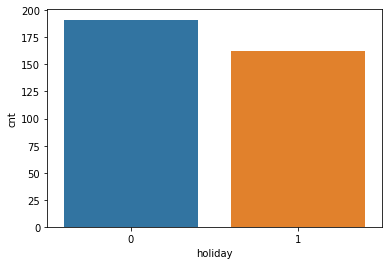

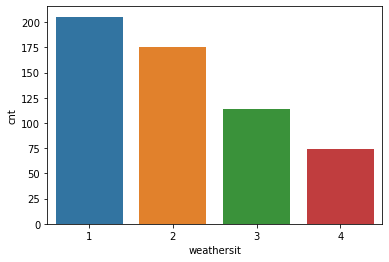

In [6]:
x_col = ["holiday","weathersit"]
for x in x_col:
    sns.barplot(data=train.dfh, x=x, y="cnt", estimator=np.mean, ci=None)
    plt.show()

Voor holidays tegen verhuur aantal, zien we dat op gemiddelijk niet verschil heeft. Dus holidays is niet van belang of het product meer of minder verhuurd wordt.  
Terwijl voor het situatie van het weer, zien we dat hoe slechter het weer is hoe minder er verhuurd wordt. Dus het weer is wel van belang.

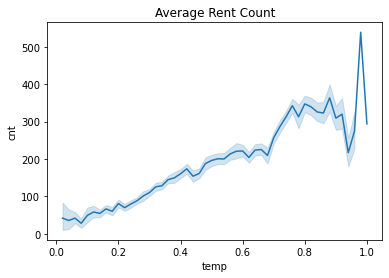

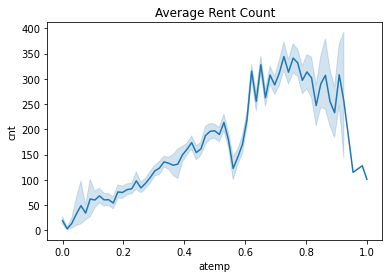

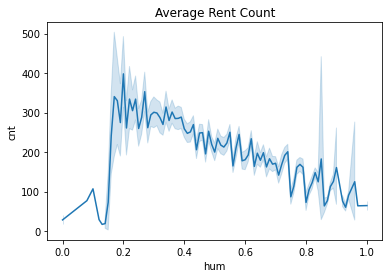

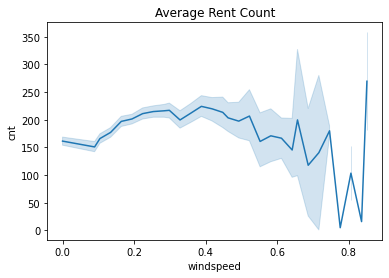

In [7]:
x_col = ["temp", "atemp", "hum", "windspeed"]

for x in x_col:
    sns.lineplot(data=train.dfh, x=x, y="cnt", estimator=np.mean)
    plt.title("Average Rent Count")
    plt.show()

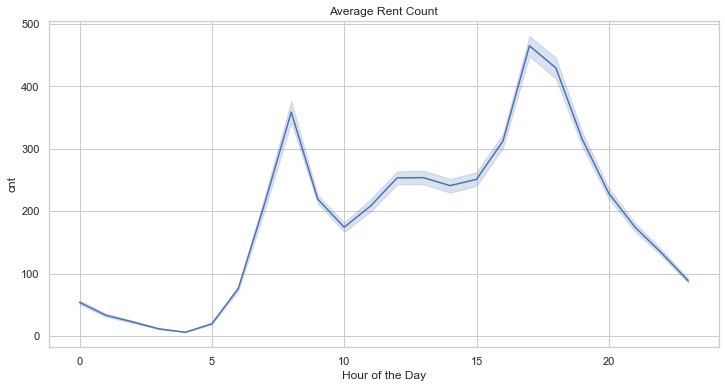

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Hour", y="cnt", estimator=np.mean)
plt.title("Average Rent Count")
plt.xlabel("Hour of the Day")
plt.show()

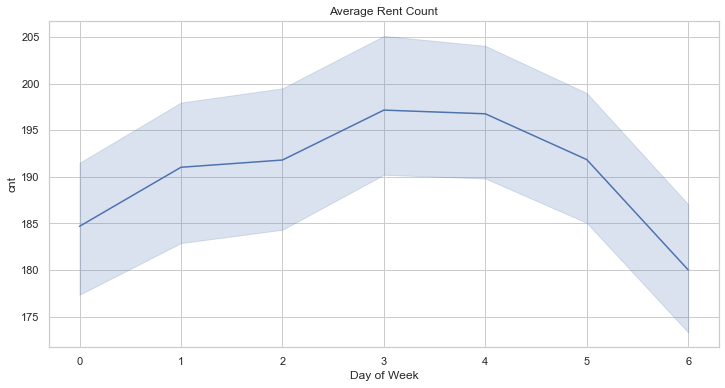

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Day_of_Week", y="cnt", estimator=np.mean)
plt.title("Average Rent Count")
plt.xlabel("Day of Week")
plt.show()

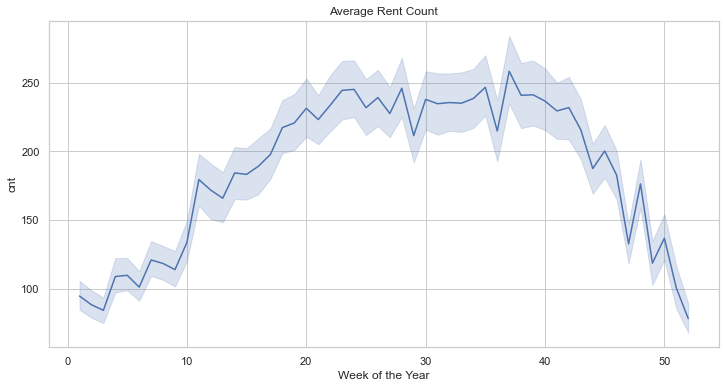

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Week", y="cnt", estimator=np.mean)
plt.title("Average Rent Count")
plt.xlabel("Week of the Year")
plt.show()

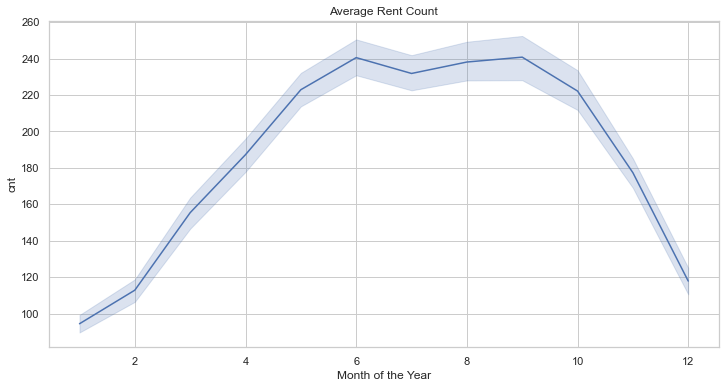

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Month", y="cnt", estimator=np.mean)
plt.title("Average Rent Count")
plt.xlabel("Month of the Year")
plt.show()

holiday       -0.026586
weathersit    -0.140111
temp           0.409245
atemp          0.404820
hum           -0.327288
windspeed      0.097006
cnt            1.000000
Year           0.266739
Month          0.140023
Day_of_Week   -0.002969
Hour           0.396945
Week           0.130888
Name: cnt, dtype: float64


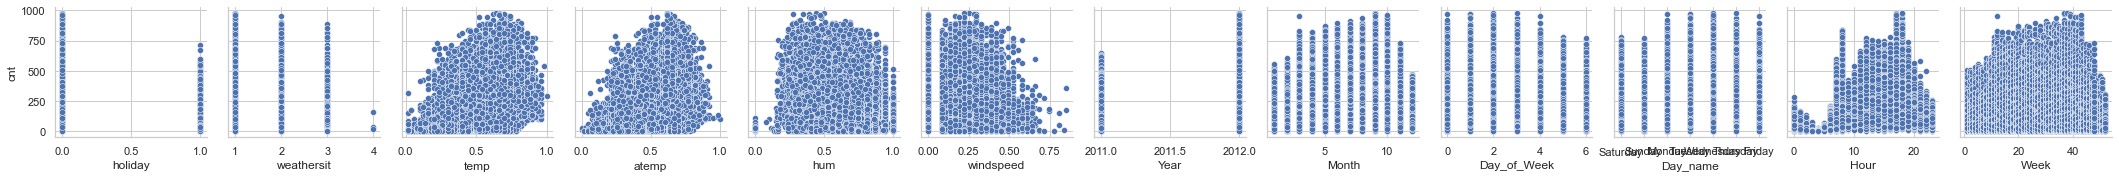

In [27]:
x_cols = train.dfh.columns.drop('cnt')
print(train.dfh.corr()['cnt'])
fig = sns.pairplot(
    train.dfh,
    x_vars=x_cols,
    y_vars='cnt'
)
plt.show()

## Timeseries Feature Engineering

### FFT

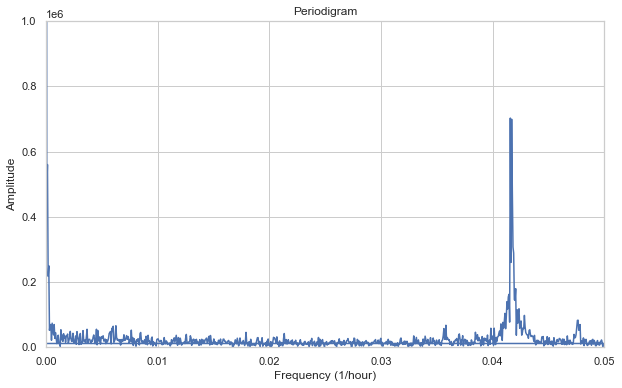

In [12]:
tijdreeks = train.dfh['cnt']
n = len(tijdreeks)
freq = np.fft.fftfreq(n,1)
fft_result = fft(tijdreeks)

plt.figure(figsize=(10, 6))
plt.plot(freq, np.abs(fft_result))
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Amplitude')
plt.xlim([0,0.05])
plt.ylim([0,1e6])
plt.title('Periodigram')
plt.grid(True)
plt.show()

In [13]:
df_fft = pd.DataFrame(np.abs(fft_result))
df_fft['freq'] = freq
hours = []
days= []
for f in freq:
    if f != 0:
        hours.append(1/f)
        days.append(1/f/24)
    else:
        hours.append(np.inf)
        days.append(np.inf)
df_fft['duur in uren'] = hours
df_fft['duur in dagen'] = days
df_fft.rename(columns={0:'amplitude'}, inplace=True)
df_fft = df_fft[(df_fft['amplitude'] > 0.4e+06)&(df_fft['freq'] > 0)]
df_fft

# dagelijks patroon en jaarlijks patroon

,amplitude,freq,duur in uren,duur in dagen
1,489864.299841,0.000060,16637.000000,693.208333
2,560236.241034,0.000120,8318.500000,346.604167
692,702799.953019,0.041594,24.041908,1.001746
694,699280.808600,0.041714,23.972622,0.998859
695,479527.144257,0.041774,23.938129,0.997422


### Lags & Multistep Targets

In [14]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

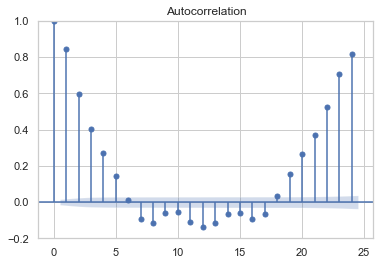

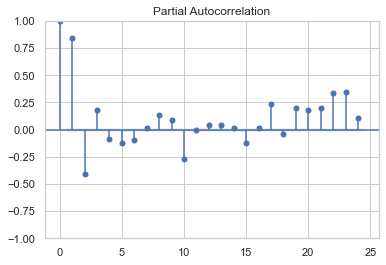

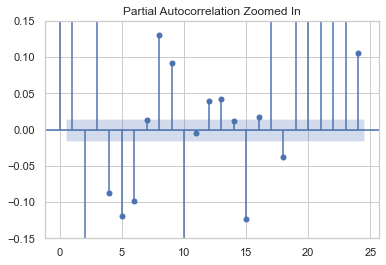

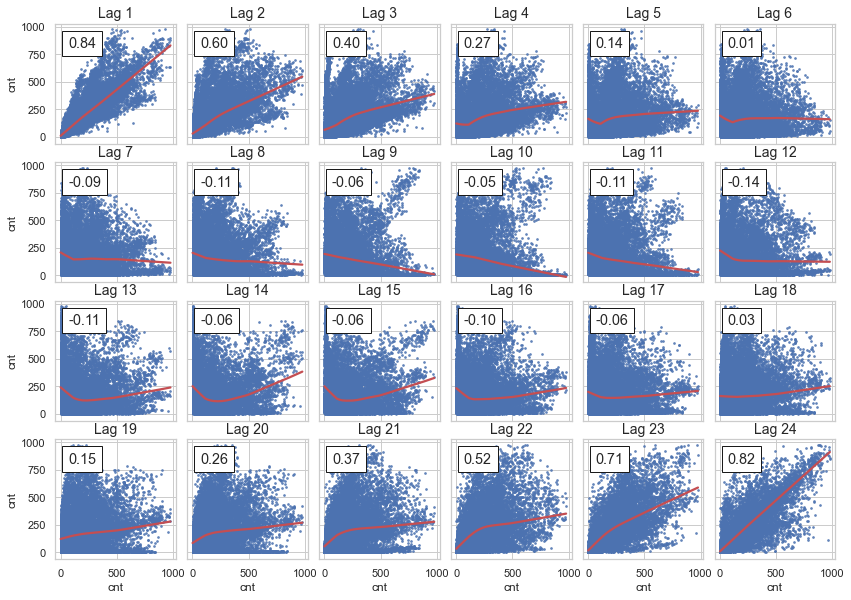

In [15]:
plot_acf(train.dfh["cnt"], lags=24)
plt.ylim(-0.2,1)
plot_pacf(train.dfh["cnt"], lags=24, method="ywm") # We zien de confidence intervals niet duidelijk.
plot_pacf(train.dfh["cnt"], lags=24, method="ywm")
plt.ylim(-0.15, 0.15)
plt.title("Partial Autocorrelation Zoomed In")
plot_lags(train.dfh["cnt"], lags=24, nrows=4)
plt.show()

# Lag 1-5

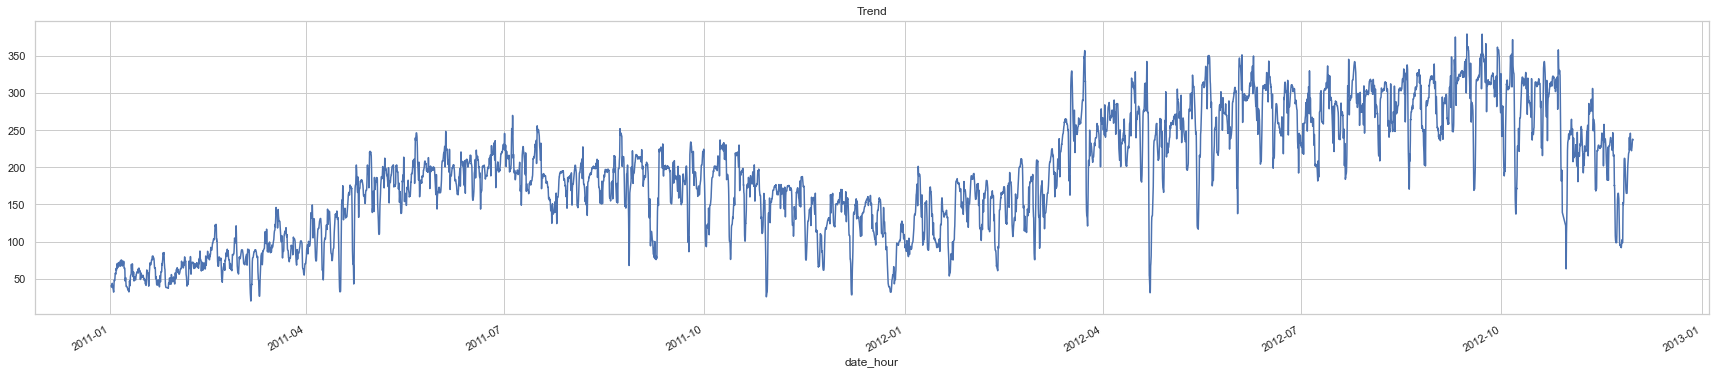

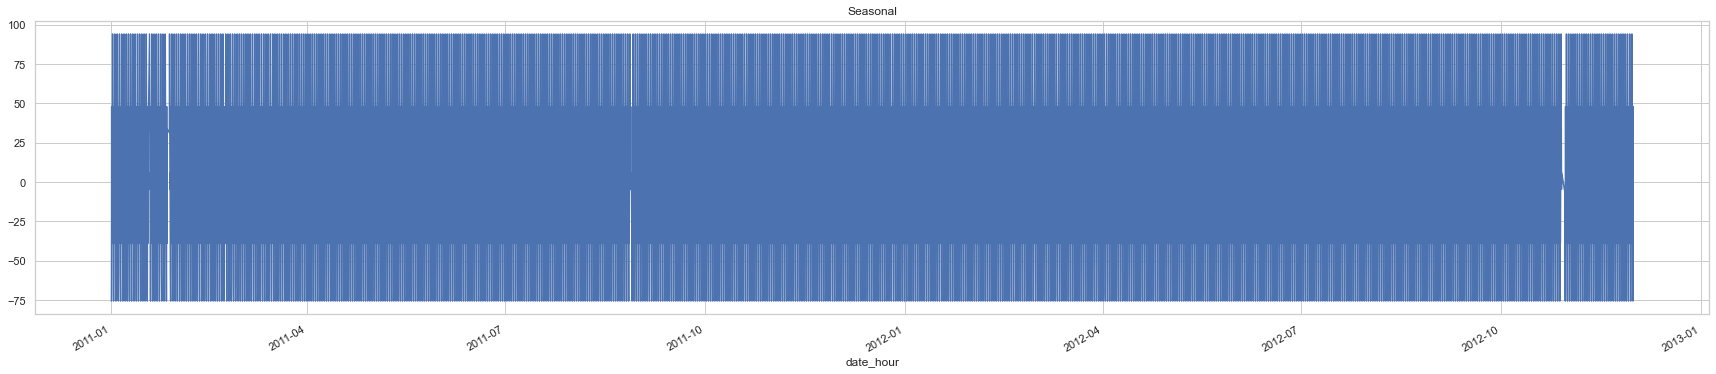

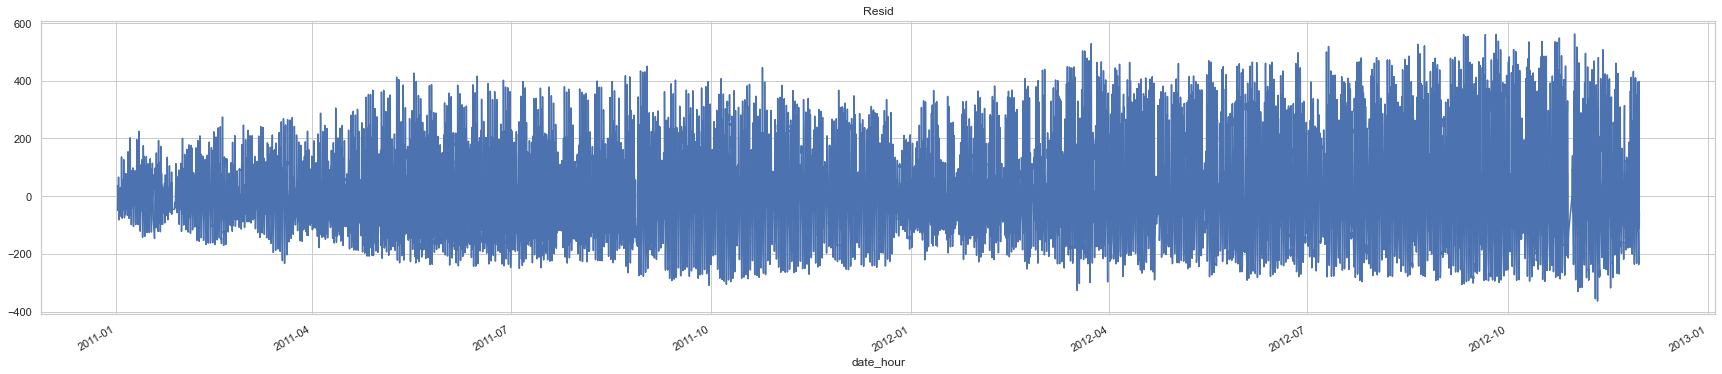

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(train.dfh['cnt'], model='additive', period=24)
plt.figure(figsize=(30,6))
plt.title("Trend")
sd.trend.plot()
plt.figure(figsize=(30,6))
plt.title("Seasonal")
sd.seasonal.plot()
plt.figure(figsize=(30,6))
plt.title("Resid")
sd.resid.plot()
plt.show()

We hebben een dagelijkse patroon, dus we kiezen 24 voor period (data in uren).  
Op het trend grafiek, van het begin van 2011 stijgt het tot in de zomer en vanaf oktober 2011 daalt het weer tot nieuw jaar. In 2012 begint het ook met een stijging, dit stijgt tot rond april 2012 en vanaf oktober daalt het ook tot nieuwe jaar.  
Het product is trending in lente en zomer.  
De seasonal grafiek ziet er bijna een hele blok uit, het patroon geeft aan dat het een herhalend dagelijkse cyclus is. 
Uit de resid grafiek zie je hoe groot de storingen zijn in de data die niet in de trend en seasonal zitten.

### Timeseries Features

In [17]:
# All columns has to be numeric. Make dummies or drop them.
df = pd.get_dummies(train.dfh, "Day_name")
X_train = df.drop("cnt", axis=1)
y_train = df["cnt"]
X_test = pd.get_dummies(test.dfh, "Day_name")


# Create fourier
# We saw that there is a Yearly and Daily pattern.
# There are other peaks very close to the Daily frequency, we'll test with different orders.
fourier = CalendarFourier(freq='A', order = 1) # A-Annual
fourier2 = CalendarFourier(freq='D', order = 1) # D-Daily

dp = DeterministicProcess(index=X_train.index, constant=False, order=1, seasonal=False,
                          additional_terms = [fourier, fourier2], drop = True)
X_train2 = dp.in_sample()
X_test2 = dp.out_of_sample(steps = len(X_test),forecast_index=X_test.index)

X_train = pd.concat([X_train, X_train2], axis=1)
X_test = pd.concat([X_test, X_test2], axis=1)
display(X_train.head(), X_test.head())

,holiday,weathersit,temp,atemp,hum,windspeed,Year,Month,Day_of_Week,Hour,...,Day_name_Saturday,Day_name_Sunday,Day_name_Thursday,Day_name_Tuesday,Day_name_Wednesday,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,2011,1,5,0,...,1,0,0,0,0,1.0,0.000000,1.000000,0.000000,1.000000
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,2011,1,5,1,...,1,0,0,0,0,2.0,0.000717,1.000000,0.258819,0.965926
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,2011,1,5,2,...,1,0,0,0,0,3.0,0.001435,0.999999,0.500000,0.866025
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,2011,1,5,3,...,1,0,0,0,0,4.0,0.002152,0.999998,0.707107,0.707107
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,2011,1,5,4,...,1,0,0,0,0,5.0,0.002869,0.999996,0.866025,0.500000


,holiday,weathersit,temp,atemp,hum,windspeed,Year,Month,Day_of_Week,Hour,...,Day_name_Saturday,Day_name_Sunday,Day_name_Thursday,Day_name_Tuesday,Day_name_Wednesday,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,,,,,,,,,,,,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,2012,12,5,0,...,1,0,0,0,0,16638.0,-0.507415,0.861702,0.000000,1.000000
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,2012,12,5,1,...,1,0,0,0,0,16639.0,-0.506799,0.862064,0.258819,0.965926
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2012,12,5,2,...,1,0,0,0,0,16640.0,-0.506182,0.862427,0.500000,0.866025
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,2012,12,5,3,...,1,0,0,0,0,16641.0,-0.505565,0.862789,0.707107,0.707107
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,2012,12,5,4,...,1,0,0,0,0,16642.0,-0.504948,0.863150,0.866025,0.500000


In [18]:
X = make_lags(X_train, lags=5)
X.fillna(0.0, inplace=True)

test = make_lags(X_test, lags=5)
test.fillna(0.0, inplace=True)

y = make_multistep_target(y_train, steps=7*24).dropna()

y, X = y.align(X, join='inner', axis=0)

In [19]:
# from statsmodels.tsa.arima.model import ARIMA

# order = (5,1,0)

# # Fit the ARIMA model
# model = ARIMA(X, order=order)
# fitted_model = model.fit()

# # Forecast using the fitted model
# forecast, stderr, conf_int = fitted_model.forecast(steps=len(test))

# # Visualize the results
# plt.figure(figsize=(12, 6))
# plt.plot(X.index, X, label='Train')
# plt.plot(test.index, test, label='Test')
# plt.plot(test.index, forecast, label='Forecast', color='red')
# plt.legend()
# plt.title('ARIMA Forecast')

## Modelleren

In [20]:
display(X.head(), y.head(), test.head())

y_lag_1                                                   \
                    holiday weathersit  temp   atemp   hum windspeed    Year   
date_hour                                                                      
2011-01-01 00:00:00     0.0        0.0  0.00  0.0000  0.00       0.0     0.0   
2011-01-01 01:00:00     0.0        1.0  0.24  0.2879  0.81       0.0  2011.0   
2011-01-01 02:00:00     0.0        1.0  0.22  0.2727  0.80       0.0  2011.0   
2011-01-01 03:00:00     0.0        1.0  0.22  0.2727  0.80       0.0  2011.0   
2011-01-01 04:00:00     0.0        1.0  0.24  0.2879  0.75       0.0  2011.0   

                                            ...           y_lag_5  \
                    Month Day_of_Week Hour  ... Day_name_Saturday   
date_hour                                   ...                     
2011-01-01 00:00:00   0.0         0.0  0.0  ...               0.0   
2011-01-01 01:00:00   1.0         5.0  0.0  ...               0.0   
2011-01-01 02:00:00   1.0         5.0  1.0  ...               0.0   
2011-01-01 03:00:00   1.0         5.0  2.0  ...               0.0   
2011-01-01 04:00:00   1.0         5.0  3.0  ...               0.0   

                                                                        \
                    Day_name_Sunday Day_name_Thursday Day_name_Tuesday   
date_hour                                                                
2011-01-01 00:00:00             0.0               0.0              0.0   
2011-01-01 01:00:00             0.0               0.0              0.0   
2011-01-01 02:00:00             0.0               0.0              0.0   
2011-01-01 03:00:00             0.0               0.0              0.0   
2011-01-01 04:00:00             0.0               0.0              0.0   

                                                                \
                    Day_name_Wednesday trend sin(1,freq=A-DEC)   
date_hour                                                        
2011-01-01 00:00:00                0.0   0.0               0.0   
2011-01-01 01:00:00                0.0   0.0               0.0   
2011-01-01 02:00:00                0.0   0.0               0.0   
2011-01-01 03:00:00                0.0   0.0               0.0   
2011-01-01 04:00:00                0.0   0.0               0.0   

                                                                   
                    cos(1,freq=A-DEC) sin(1,freq=D) cos(1,freq=D)  
date_hour                                                          
2011-01-01 00:00:00               0.0           0.0           0.0  
2011-01-01 01:00:00               0.0           0.0           0.0  
2011-01-01 02:00:00               0.0           0.0           0.0  
2011-01-01 03:00:00               0.0           0.0           0.0  
2011-01-01 04:00:00               0.0           0.0           0.0  

[5 rows x 115 columns]

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,...,y_step_159,y_step_160,y_step_161,y_step_162,y_step_163,y_step_164,y_step_165,y_step_166,y_step_167,y_step_168
date_hour,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,16,40.0,32.0,13.0,1.0,1.0,2.0,3.0,8.0,14.0,...,39.0,36.0,15.0,25.0,16.0,16.0,7.0,1.0,5.0,2.0
2011-01-01 01:00:00,40,32.0,13.0,1.0,1.0,2.0,3.0,8.0,14.0,36.0,...,36.0,15.0,25.0,16.0,16.0,7.0,1.0,5.0,2.0,9.0
2011-01-01 02:00:00,32,13.0,1.0,1.0,2.0,3.0,8.0,14.0,36.0,56.0,...,15.0,25.0,16.0,16.0,7.0,1.0,5.0,2.0,9.0,15.0
2011-01-01 03:00:00,13,1.0,1.0,2.0,3.0,8.0,14.0,36.0,56.0,84.0,...,25.0,16.0,16.0,7.0,1.0,5.0,2.0,9.0,15.0,20.0
2011-01-01 04:00:00,1,1.0,2.0,3.0,8.0,14.0,36.0,56.0,84.0,94.0,...,16.0,16.0,7.0,1.0,5.0,2.0,9.0,15.0,20.0,61.0


y_lag_1                                                   \
                    holiday weathersit  temp   atemp   hum windspeed    Year   
date_hour                                                                      
2012-12-01 00:00:00     0.0        0.0  0.00  0.0000  0.00    0.0000     0.0   
2012-12-01 01:00:00     0.0        1.0  0.26  0.3030  0.81    0.0000  2012.0   
2012-12-01 02:00:00     0.0        1.0  0.26  0.3030  0.81    0.0000  2012.0   
2012-12-01 03:00:00     0.0        2.0  0.26  0.3030  0.81    0.0000  2012.0   
2012-12-01 04:00:00     0.0        2.0  0.26  0.2727  0.81    0.1343  2012.0   

                                            ...           y_lag_5  \
                    Month Day_of_Week Hour  ... Day_name_Saturday   
date_hour                                   ...                     
2012-12-01 00:00:00   0.0         0.0  0.0  ...               0.0   
2012-12-01 01:00:00  12.0         5.0  0.0  ...               0.0   
2012-12-01 02:00:00  12.0         5.0  1.0  ...               0.0   
2012-12-01 03:00:00  12.0         5.0  2.0  ...               0.0   
2012-12-01 04:00:00  12.0         5.0  3.0  ...               0.0   

                                                                        \
                    Day_name_Sunday Day_name_Thursday Day_name_Tuesday   
date_hour                                                                
2012-12-01 00:00:00             0.0               0.0              0.0   
2012-12-01 01:00:00             0.0               0.0              0.0   
2012-12-01 02:00:00             0.0               0.0              0.0   
2012-12-01 03:00:00             0.0               0.0              0.0   
2012-12-01 04:00:00             0.0               0.0              0.0   

                                                                \
                    Day_name_Wednesday trend sin(1,freq=A-DEC)   
date_hour                                                        
2012-12-01 00:00:00                0.0   0.0               0.0   
2012-12-01 01:00:00                0.0   0.0               0.0   
2012-12-01 02:00:00                0.0   0.0               0.0   
2012-12-01 03:00:00                0.0   0.0               0.0   
2012-12-01 04:00:00                0.0   0.0               0.0   

                                                                   
                    cos(1,freq=A-DEC) sin(1,freq=D) cos(1,freq=D)  
date_hour                                                          
2012-12-01 00:00:00               0.0           0.0           0.0  
2012-12-01 01:00:00               0.0           0.0           0.0  
2012-12-01 02:00:00               0.0           0.0           0.0  
2012-12-01 03:00:00               0.0           0.0           0.0  
2012-12-01 04:00:00               0.0           0.0           0.0  

[5 rows x 115 columns]

In [44]:
models = {
    "lr": {
        "model":LinearRegression(),
        "params":{}
    },
    "dt": {
        "model":DecisionTreeRegressor(), 
        "params":{
            "criterion":["squared_error","friedman_mse","absolute_error","poisson"],
            "splitter":["best", "random"],
            "max_depth":[None,30,35]
        }
    },
    "rf": {
        "model":RandomForestRegressor(random_state=42, n_jobs=-1), 
        "params":{"criterion":["squared_error","friedman_mse","absolute_error","poisson"],
                  "max_depth": [None,30,35]}
    },
    "gb": {
        "model":GradientBoostingRegressor(random_state=42), 
        "params":{"loss":["squared_error","absolute_error","huber","quantile"],
                  "criterion":["squared_error","friedman_mse"],
                  "max_depth":[None,30,35],
                  "learning_rate":[0.01,0.1,1.0]}
    },
    "ada": {
        "model":AdaBoostRegressor(), 
        "params":{"loss":["linear","square","exponential"],
                  "n_estimators":[50,100,150],
                  "learning_rate":[0.01, 0.1, 1.0],
                  "base_estimator__max_depth":[None, 30, 35]}
    }
              }

In [45]:
best_models = {}
best_params = {}
best_scores = {}

for model_name, config in models.items():
    grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    grid_search.fit(X, y)
    
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    
    cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    best_scores[model_name] = cross_val_scores.mean()
    
for model_name, best_model in best_models.items():
    print(f"Best model for {model_name}: {best_model}")
    print(f"Best parameters for {model_name}: {best_params[model_name]}")
    print(f"Cross-validation score for {model_name}: {best_scores[model_name]}")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [22]:
# Hybride model
X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(X, y, test_size=7*24, shuffle=False)

# DeterministicProcess
fourier = CalendarFourier(freq='A', order = 1) # A-Annual
fourier2 = CalendarFourier(freq='D', order = 1) # D-Daily

dp = DeterministicProcess(index=X_train_H.index, constant=False, order=1, seasonal=False,
                          additional_terms = [fourier, fourier2], drop = True)
X_train2_H = dp.in_sample()
X_test2_H = dp.out_of_sample(steps = len(y_test_H),forecast_index=y_test_H.index)

# Pick 2 models
model1 = LinearRegression()
model2 = DecisionTreeRegressor()

model1.fit(X_train_H, y_train_H)
train_predict1 = model1.predict(X_train_H)
test_predict1 = model1.predict(X_test_H)

y_train_res = y_train_H - train_predict1
y_test_res = y_test_H - test_predict1

model2.fit(X_train2_H, y_train_res)
train_predictions_total = model2.predict(X_train2_H) + train_predict1
test_predictions_total = model2.predict(X_test2_H) + test_predict1

print('train r2', r2_score(y_train_H, train_predictions_total))
print('test r2', r2_score(y_test_H, test_predictions_total))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


train r2 1.0
test r2 -0.06055330708221004


In [30]:
models_dict = {'lr': [LinearRegression(), {}],
               'dt': [DecisionTreeRegressor(random_state=SEED), {'max_depth': [30]}],
               'rf': [RandomForestRegressor(n_jobs=-1, random_state=SEED), {'max_depth': [30]}],
               'gb': [GradientBoostingRegressor(random_state=SEED), {'loss': ['squared_error'],
                                                                     'learning_rate': [0.1]}]}

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'lr': [{}, -81.18892083882488], 'dt': [{'max_depth': 30}, 0.6792118091579635], 'rf': [{'max_depth': 30}, 0.8138981855782004], 'gb': [{'learning_rate': 0.1, 'loss': 'squared_error'}, 0.6871867120395228]} rf 0.8138981855782004 {'max_depth': 30}
fit_predict RandomForestRegressor(max_depth=30, n_jobs=-1, random_state=1337)


C:\Users\samke\AppData\Local\Temp\ipykernel_26572\1470999369.py:84: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(self.X_train, self.y_train)


train r2 RandomForestRegressor(max_depth=30, n_jobs=-1, random_state=1337) 0.9931279555665856
test r2 RandomForestRegressor(max_depth=30, n_jobs=-1, random_state=1337) 0.29786735921868024


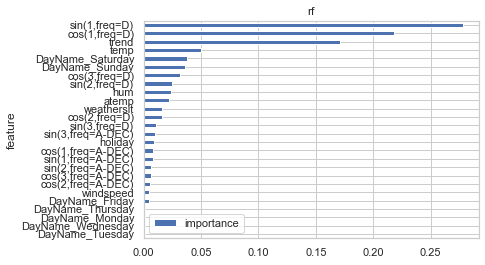

In [42]:
data = RegressionModels(data=dfh_train.dfh, dummie_cols=['DayName'],drop=['hour', 'week', 'month', 'year', 'season'] ,target='cnt', shuffle=False, test_size=7*24)
data.DeterministicProcess(order=1, fourier_terms=[('A', 3), ('D', 3)])
data.concat()
data.tune_params(n_splits=52, models_dict=models_dict)
print(data.results, data.best_model, data.best_score, data.best_params)
data.predict()
data.feature_imp()

## Uitleg:


### Lineaire Regressie:


De Lineaire regressie is een algoritme dat met een lineair verband tussen variabelen een uitkomst van een variabel probeert te voorspellen.  Je hebt twee vormen van lineaire regressie, simpele lineaire regressie en meervoudige lineaire regressie. Bij simpele lineaire regressie probeer je erachter te komen hoeveel invloed 1 variabel heeft op een ander variabel. Bij een meervoudige lineaire regressie probeer je erachter te komen hoeveel invloed meerdere variabelen hebben op 1 variabel. Voor een lineaire regressie is het belangrijk dat de variabel die je probeert te voorspellen in principe alles kan zijn en niet categorisch, ook moet er een normale verdeling zijn. Als de variabel die je probeert te voorspellen wel categorisch is, kan je beter het algoritme gebruiken dat er erg op lijkt, namelijk de logische regressie. De functie voor een simpele regressie is:
y = b * x + a, hierbij is a waar de lijn de y as raakt, b de gradiënt van de lijn, x de variabel waarmee je probeert te voorspellen en y de variabel die je wil voorspellen. De meervoudige lineaire regressie formule lijkt zeer op de formule van de simpele regressie namelijk:
y= b1*x1 + b2 * x2 + … + bk * xk , hierbij zijn y en a  hetzelfde als bij de simpele regressie alleen heb je hierbij meer variabele die je gebruikt voor het voorspellen dus heb je daarom voor elk variabel een eigen x en bijbehorende b. (T-Test, Chi-Square, ANOVA, Regression, Correlation. . ., z.d.)

#### Loss Functie:


 De lossfunctie voor een lineaire regressie is de laagst mogelijke Mean Squared Error. De functie hiervoor is:

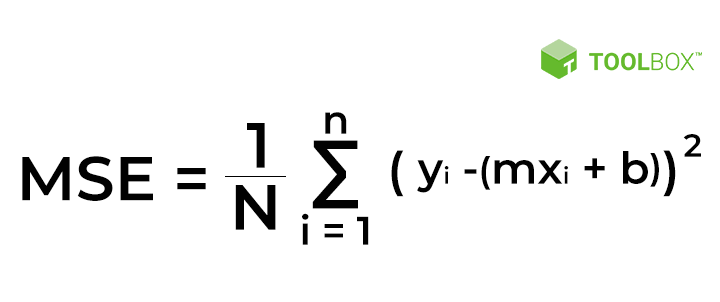

Hierbij is N de hoeveelheid data punten, 1/N∑ni=1 de gemiddelde van al die data punten, yi de echte waarden van een variabel en mxi+b de verwachte waarden van het variabel. Hier doe je dan via gradient descent de MSE zoveel mogelijk proberen te verlagen waardoor je model zo efficient mogelijk wordt. (What is linear regression?- Spiceworks - Spiceworks, 2023)

#### Regularisatie:

Nadat je een model getraind hebt komt het vaak voor dat je model ‘overfit’ is dus te veel naar de trainingsdata kijkt waardoor die de uitkomst van nieuwe data slechter kan voorspellen. Een manier om dit tegen te gaan is regularisatie. Regularisatie werkt door de loss functie aan te passen, je voegt dan een soort van ‘penalty’ toe om soort van de voorspelde coefficienten te verkleinen. Lineaire regressie heeft 2 hoofd manieren om te regulariseren, dat zijn: Ridge Regression (oftewel L2) en Lasso (oftewel L1). (Akalin, 2020)
##### Ridge Regression:
Bij Ridge Regression voeg je de penalty toe van λ∑(b_1)^2 aan de loss functie. Met deze penalty verklein je de coefficienten zo dicht mogelijk naar de 0 zonder ook echt 0 te worden. De formule bestaat uit λ wat de regulisatieparameter is en hiermee bepaal je hoe sterk de regularisatie invloed heeft op het model. Deze waarde is altijd positief en hoe hoger de waarde hoe sterker de regularisatie. Daarna heb je ∑, dit symbool betekent sommatie en betekent dus dat je alle coëfficiënten van het model meeneemt. Als laatste heb je de b_1 dit zijn de coëfficiënten van alle features van het model en die doe je in het kwadraat. Dus in principe neem je de kwadraten van alle coëfficiënten en die tel je bij elkaar op en dat vermenigvuldig je met de regulistatieparameter. En deze penalty tel je dan bij de loss functie op. De uiteindelijk functie voor de loss functie met L2 is dus dan: log loss + λ∑(b_1)^2 (Akalin, 2020)
##### Lasso:
De Lasso lijkt veel op de Ridge regression. Bij de lasso neem je in plaats van het kwadraat van de coëfficiënten gebruik je de absolute waardes van de coëfficiënten de penalty ziet er dan als volgt uit λ∑|b_1|. Hierdoor kiest het model soort van de belangrijkere variabelen uit en kan de coëfficiënt 0 worden wat bij Ridge Regression niet kan. De uiteindelijke functie voor de loss functie met L1 wordt dan: log loss + λ∑|b_1|. (Akalin, 2020)


### Ensemble:

Ensemble modellen zijn kort door de bocht eigenlijk gewoon een mix van meerdere modellen om je voorspelling beter te maken. Er zijn veel verschillende soorten ensemble modellen, dus daarom geven wij een breed overzicht van hoe je ensemble modellen kan gebruiken. We gebruiken in het overzicht M1, M2, …, Mn om de verschillende modellen aan te geven. y1, y2, …, yn zijn de voorspelde y waardes bij een gegeven x waarden bij de desbetreffende modellen. Een simpele manier een ensemble model te maken is door het gemiddelde te nemen van de modellen, de functie ziet er dan zo uit: 

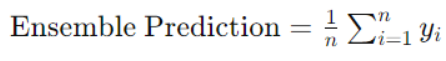

Als je zou willen dat een paar modellen belangrijker zijn dan andere modellen kan je ook nog een ‘gewicht’ toevoegen aan elk model. De functie komt er dan zo uit te zien: 

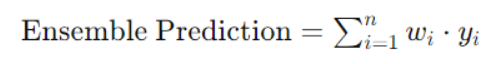

Voor classificatie problemen is het handig om een ensemble model te maken via ‘majority voting’. Een classificatie model geeft een class terug als voorspelling, bij majority voting kies je dus voor de class die het meest uit je modellen zijn gekomen. De functie hiervoor ziet er dan ook zo uit: 

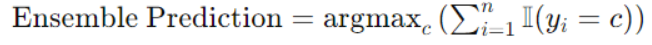

Er zijn nog veel meer manieren om een ensemble modellen te bouwen maar deze 2 manieren zijn de ensemble modellen die het vaakst voorkomen. [ChatGPT, 2023, Prompt: Ensemble Models in ML](https://chat.openai.com/share/ea17d7d6-c283-4fa4-bf53-2a3e773e8fa9)

### Decision Tree:

Decision Tree start met een root node en split de data continu in subsets afhankelijk van de features. De nodes tussen het begin en eind zijn de internal nodes, hetzelfde hoe de root node is verdeeld in twee nodes, so ook voor de internal nodes afhankelijk van de features. En aan het eind komt de leaf nodes. Dat is een Decision Tree. Dus wanneer er predictions wordt gemaakt, loopt het afhankelijk van de features vanaf de root node door totdat het bij een leaf node komt.
De keuze wordt gemaakt door het vergelijken van de feature value van de input data met de drempelwaarde, dan loopt het naar de volgende internal node of leaf node. [ChatGPT, 2023, Prompt: Decision Tree explained](https://chat.openai.com/share/8d95dc54-c1e2-4cef-9403-60e95a25057d)

Gini Impurity of Gini Index en Entropy zijn metrics die gebruikt wordt om de onzuiverheid of wanorde van een verzameling gegevenspunten in een Decision Tree node te meten. Het wordt vaak gebruikt als een criterium voor het splitsen van knooppunten in een Decision Tree tijdens het boomvormingsproces, vooral bij classification taken. Het gebruik maken van Gini Impurity of Entropy hangt af van de dataset en het gedrag van de impurities tot de dataset. De range van Gini Impurity is 0-0.5 en van Entropy is 0-1. [ChatGPT, 2023, Prompt: Gini and Entropy explained](https://chat.openai.com/share/c8a5d2a0-07d5-4d46-9584-48ad7ab60106)

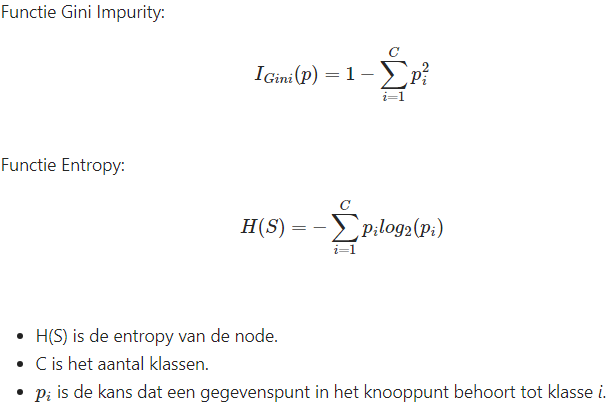

Zoals er boven verteld wordt hoe een decision tree werkt, hier zie je dat er vanuit de root node gekeken wordt naar glucose en gesplitst dan wordt naar de internal nodes totdat we bij de leaf komen. Je kan zie hoeveel samples elk subset bevat.

### Random Forest:

Random Forest is een ensemble algoritme voor machine learning dat gebruikt wordt voor zowel classification als regression. Het is een krachtige techniek die de voorspellingen van meerdere Decision Trees combineert om nauwkeurigere en robuustere resultaten te produceren. De term "ensemble" in machine learning verwijst naar de praktijk van het combineren van meerdere modellen om de algemene prestaties te verbeteren. [ChatGPT, 2023, Prompt: Random Forest Explained](https://chat.openai.com/share/a10e42a4-73b4-4a20-a2fe-2ef63e959dc9)

### Gradient Boosting:

Gradient Boosting kan met verschillende modellen werken. Neem Decision Tree als voorbeeld. Gradient Boosting start met 1 Tree (dit is het huidige model), nadien wordt de errors, die resten wordt genoemd, berekend. De nieuwe Tree (weak learner) zal deze errors voorspellen om nieuwe patterns te vinden. De voorspelling van de weak learner wordt dan toegevoegd aan het huidige model, daardoor wordt de voorspelling verbeterd. De bijdrage van elk weak learner wordt gewogen door middel van zijn prestatie. De uiteindelijke voorspelling wordt gemaakt door de voorspellingen van alle weak learners samen te voegen, elk gewogen door zijn prestatie in het verminderen van de residuen. [ChatGPT, 2023, Prompt: Gradient Boosting explained](https://chat.openai.com/share/600a5556-3e15-428f-aecb-d41a8674fddb)

### Ada Boosting:

Alle training examples krijgen hetzelfde gewicht, daarna worden ze iterated. Bij elke iteratie wordt het gewicht aangepast door de vorige voorspellingen van de weak learners. Verder wordt er getraind op de training data met het huidig gewicht. De weak learner let op de examples die verkeerd geclassificeerd zijn, omdat zij een hogere gewicht krijgen. Nadat de weak learner getraind is, berekent ADA Boost een gewicht op basis van zijn nauwkeurigheid. [ChatGPT, 2023, Prompt: ADA Boosting explained](https://chat.openai.com/share/600a5556-3e15-428f-aecb-d41a8674fddb)

### SARIMAX:

SARIMAX is een time series voorspel model die verder op ARIMA gaat doormiddel van meer features toevoegen en door rekening te houden met exogene variabelen en seizoensgebondenheid. SARIMAX staat letterlijk voor Seasonal AutoRegressive Integrated Moving Average with eXogenous variables. 
Seasonal staat hiervoor het seizoensgebondenheid van de data, het houd rekening met patronen die zich regelmatig voortdoen.
AutoRegressive staat voor de relatie tussen een observatie en eerdere observaties (ook wel 'lagged' observaties genoemd)
Integrated staat voor naar de verschillen te kijken tussen de data punten, hierdoor maak je de data meer voorspelbaar en stabiel.
Moving Average houdt zicht rekening met willekeurige onverwachtse veranderingen in het model
eXogenous houdt in dat dit de variabele zijn die wel invloed hebben op de time series data maar niet een deel zijn van de time series data zelf. [ChatGPT, 2023, Prompt: SARIMAX for Time Series](https://chat.openai.com/share/5f66e6fc-d299-432c-9b7e-bec00b756e22)

## Bronnenlijst:

What is linear regression?- Spiceworks - Spiceworks. (2023, 3 april). Spiceworks. https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-linear-regression/

T-Test, Chi-Square, ANOVA, Regression, Correlation. . . (z.d.). https://datatab.net/tutorial/linear-regression

Akalin, A. (2020, 30 september). 5.13 Logistic Regression and Regularization | Computational Genomics with R. https://compgenomr.github.io/book/logistic-regression-and-regularization.html

[ChatGPT, 2023, Prompt: Decision Tree explained](https://chat.openai.com/share/8d95dc54-c1e2-4cef-9403-60e95a25057d) 

[ChatGPT, 2023, Prompt: Gini and Entropy explained](https://chat.openai.com/share/c8a5d2a0-07d5-4d46-9584-48ad7ab60106) 

[ChatGPT, 2023, Prompt: Random Forest Explained](https://chat.openai.com/share/a10e42a4-73b4-4a20-a2fe-2ef63e959dc9)  

[ChatGPT, 2023, Prompt: Gradient Boosting explained](https://chat.openai.com/share/600a5556-3e15-428f-aecb-d41a8674fddb)

[ChatGPT, 2023, Prompt: ADA Boosting explained](https://chat.openai.com/share/600a5556-3e15-428f-aecb-d41a8674fddb)  

[ChatGPT, 2023, Prompt: Ensemble Models in ML](https://chat.openai.com/share/ea17d7d6-c283-4fa4-bf53-2a3e773e8fa9)

[ChatGPT, 2023, Prompt: SARIMAX for Time Series](https://chat.openai.com/share/5f66e6fc-d299-432c-9b7e-bec00b756e22)